In [2]:
#Practical 4
#importing numpy and pandas.
import numpy as np
import pandas as pd

In [3]:
#Define a function to contruct the sparse matrix.
def sparse_split(filer):
    import csv
    with open(filer, 'r') as file:
        reader = csv.reader(file) #reading the file
        
        #mapping the users and movies into indexes
        map_user_to_idx = {}
        map_movie_to_idx = {}
        
        #relation between the indexes, the users and the movies.
        map_idx_to_user = []
        map_idx_to_movie = []
        
        #listes respectively for each type of data.
        data_by_user_train = []
        data_by_user_test = []
        data_by_movie_train = []
        data_by_movie_test = []
        data_by_user = []
        data_by_movie = []
        
        #Taking each line of the data one by one.
        for row in reader:
            user = row[0] # taking the user
            movie = row[1] #taking the movie
            rating = row[2] #taking the rating
            
            if user =='userId': #Do not consider the first line.
                continue
              
            if user not in map_user_to_idx: #creating the list for the new user.
                map_user_to_idx[user] = len(map_user_to_idx)
                map_idx_to_user.append(user)
                data_by_user_train.append([])
                data_by_user_test.append([])
                data_by_user.append([])
                
                
            if movie not in map_movie_to_idx: #creating the list for the new movie
                map_movie_to_idx[movie]=len(map_movie_to_idx)
                map_idx_to_movie.append(movie)
                data_by_movie_train.append([])
                data_by_movie_test.append([])
                data_by_movie.append([])
            
            #completing the main data.
            data_by_user[map_user_to_idx[user]].append((map_movie_to_idx[movie],float(rating)))
            data_by_movie[map_movie_to_idx[movie]].append((map_user_to_idx[user],float(rating)))            
            
            # flip a coin
            flip = np.random.rand()
            if flip < 0.05: #for the test
                data_by_user_test[map_user_to_idx[user]].append((map_movie_to_idx[movie],float(rating)))
                data_by_movie_test[map_movie_to_idx[movie]].append((map_user_to_idx[user],float(rating)))
            else: #for the train
                data_by_user_train[map_user_to_idx[user]].append((map_movie_to_idx[movie],float(rating)))
                data_by_movie_train[map_movie_to_idx[movie]].append((map_user_to_idx[user],float(rating)))
    return data_by_user, data_by_movie, data_by_user_train, data_by_movie_train, data_by_user_test, data_by_movie_test, map_idx_to_user, map_idx_to_movie, map_user_to_idx, map_movie_to_idx

In [4]:
#calling the function.
path = 'ml-25m/ratings.csv'
data_by_user, data_by_movie, data_by_user_train, data_by_movie_train, data_by_user_test, data_by_movie_test, map_idx_to_user, map_idx_to_movie, map_user_to_idx, map_movie_to_idx = sparse_split(path)

In [5]:
#function for the update users vectors.
def updtating_biases_vector_user(user_biases, movies_biases, user_vector, movie_vector, lamda, gamma, tau, data_by_user, data_by_movie):
  #updating the biases.
  for m in range (len(data_by_user)):
    bias = 0
    item_counter = 0
    for (n,r) in data_by_user[m]:
      bias+=lamda * (r-movies_biases[n]-user_biases[m]-np.dot(user_vector[m,:], movie_vector[n,:]))
      item_counter+=1
    bias=bias/(lamda*item_counter + gamma)
    user_biases[m]=bias

  #updating the embedding vectors.
  for m in range(len(data_by_user)):
    mat_vec = np.zeros((len(user_vector[m,:]),len(user_vector[m,:])))
    vec= np.zeros(len(user_vector[m,:]))
    for (n,r) in data_by_user[m]:
      vn = movie_vector[n,:]
      mat_vec += np.outer(vn,vn)
      vec += lamda*(r - user_biases[m] - movies_biases[n])*vn
    mat_vec = lamda*(mat_vec) + tau*np.eye(len(vn))
    user_vector[m,:] = np.linalg.solve(mat_vec, vec)
  return user_biases, user_vector

In [6]:
def updtating_biases_vector_movie(user_biases, movies_biases, user_vector, movie_vector, lamda, gamma, tau, data_by_user, data_by_movie):
  #updating the biases for the movies
  for n in range (len(data_by_movie)):
    bias = 0
    item_counter = 0
    for (m,r) in data_by_movie[n]:
      bias+=lamda * (r-movies_biases[n]-user_biases[m]-np.dot(user_vector[m,:], movie_vector[n,:]))
      item_counter+=1
    bias=bias/(lamda*item_counter + gamma)
    movies_biases[n]=bias


  #updating the embedding vectors.
  for n in range(len(data_by_movie)):
    mat_vec = np.zeros((len(movie_vector[n,:]),len(movie_vector[n,:])))
    vec = np.zeros(len(movie_vector[n,:]))
    for (m,r) in data_by_movie[n]:
      um = user_vector[m,:]
      mat_vec += np.outer(um,um)
      vec += lamda*(r - user_biases[m] - movies_biases[n])*um
    mat_vec = lamda*(mat_vec) + tau*np.eye(len(um))
    movie_vector[n,:] = np.linalg.solve(mat_vec, vec)
  return movies_biases, movie_vector

In [7]:
#function calculating the RMSE.
def rmse_calculate(data, biases_u, biases_v, vector_u, vector_v,lamda, gamma):
  rmse = 0
  count = 0
  for m in range (len(data)):
    for (n,r) in data[m]:
      rmse+=(r-biases_u[m]-biases_v[n]-np.dot(vector_u[m,:], vector_v[n,:]))**2
      count += 1
  rmse = rmse/count
  return np.sqrt(rmse)

In [8]:
#function calculating the loss function.
def loss_calculate(data, biases_u, biases_v, vector_u, vector_v, lamda, gamma,tau):
  loss = 0
  for m in range (len(data)):
    for (n,r) in data[m]:
      um = vector_u[m,:]
      vn = vector_v[n,:]
      bm = biases_u[m]
      bn = biases_v[n]
      loss+=(-lamda/2) * ((r - np.dot(um, vn) -bm- bn)**2)-(gamma/2)*((bm)**2+(bn)**2) - (tau/2)*(np.dot(um,um)+np.dot(vn,vn))
  return loss

In [99]:
#Training
M = len(data_by_user_train)
N = len(data_by_movie_train)
#initialize the biases
user_biases = np.zeros(M)
movies_biases = np.zeros(N)
K=10 #embedding dimension
p=1/np.sqrt(K) #ecart type of the distributions

#initialization of the embedding vectors.
user_vector = np.random.normal(0,p, (M,K))
movie_vector = np.random.normal(0,p, (N,K))
epoch = 30 #choice of the epoch
lamda = 0.002#lower
gamma = 0.055
tau = 0.01#lower

#list for the values of the losses and the RMSE.
Loss_train_list = []
Loss_test_list = []
mse_train_list = []
mse_test_list = []

for i in range (epoch):

  #calling all the functions and update with the train samples.
  user_biases, user_vector  = updtating_biases_vector_user(user_biases, movies_biases, user_vector, movie_vector, lamda, gamma, tau, data_by_user_train, data_by_movie_train)
  movies_biases, movie_vector = updtating_biases_vector_movie(user_biases, movies_biases, user_vector, movie_vector, lamda, gamma, tau, data_by_user_train, data_by_movie_train)
  Loss_train = loss_calculate(data_by_user_train, user_biases, movies_biases, user_vector, movie_vector, lamda, gamma,tau)
  rmse = rmse_calculate(data_by_user_train, user_biases, movies_biases, user_vector, movie_vector,lamda, gamma)

  mse_train_list.append(rmse)
  Loss_train_list.append(Loss_train)
  
  Loss_test = loss_calculate(data_by_user_test, user_biases, movies_biases, user_vector, movie_vector, lamda, gamma,tau)
  rmse_test = rmse_calculate(data_by_user_test, user_biases, movies_biases, user_vector, movie_vector,lamda, gamma)
 
  mse_test_list.append(rmse_test)
  Loss_test_list.append(Loss_test)

  if i<10 or (i>10 and i%10==0):
    print(f'epoch{i+1},  Loss train: {Loss_train}, Loss test: {Loss_test}, rmse : {rmse}, rmse test: {rmse_test}')



epoch1,  Loss train: -6827136.308703327, Loss test: -358880.7855972932, rmse : 0.8986790413954218, rmse test: 0.9650690309648993
epoch2,  Loss train: -4458735.586267513, Loss test: -234736.85244768584, rmse : 0.8826746012499593, rmse test: 0.9182306432563085
epoch3,  Loss train: -1771026.7347826627, Loss test: -93234.7789837817, rmse : 0.7953633640084403, rmse test: 0.8410506747604649
epoch4,  Loss train: -1628389.3652439367, Loss test: -85766.75587489798, rmse : 0.7495549671032398, rmse test: 0.799274449001116
epoch5,  Loss train: -1507440.911805116, Loss test: -79425.16126975282, rmse : 0.7429014928190941, rmse test: 0.7943728625350175
epoch6,  Loss train: -1438901.0456235292, Loss test: -75826.68431600013, rmse : 0.739226636061319, rmse test: 0.791826075093043
epoch7,  Loss train: -1399360.4545694801, Loss test: -73751.84482852899, rmse : 0.7366680848414567, rmse test: 0.7902282745148941
epoch8,  Loss train: -1377005.3164082645, Loss test: -72579.746463593, rmse : 0.7347831292816003

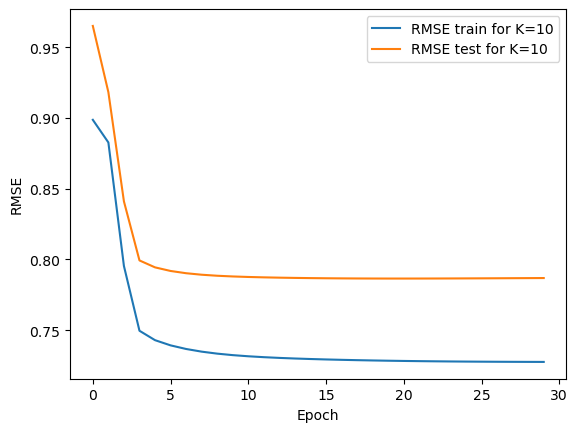

In [100]:
#Plotting the RMSE for the train and the test.
import matplotlib.pyplot as plt
plt.plot(mse_train_list, label ='RMSE train for K=10')
plt.plot(mse_test_list, label = 'RMSE test for K=10')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.savefig('toky.pract4.pdf', format = 'pdf', bbox_inches = 'tight')
plt.legend()

In [102]:
#Training
M = len(data_by_user_train)
N = len(data_by_movie_train)
#initialize the biases.
user_biases = np.zeros(M)
movies_biases = np.zeros(N)
K=20 #embedding dimension.
p=1/np.sqrt(K) #ecart type of the disstribution.

#initialize the embedding vectors.
user_vector = np.random.normal(0,p, (M,K))
movie_vector = np.random.normal(0,p, (N,K))
epoch = 20
lamda = 0.002#lower
gamma = 0.055
tau = 0.01#lower

#list for the values of the losses and the RMSE.
Loss_train_list = []
Loss_test_list = []
mse_train_list = []
mse_test_list = []

for i in range (epoch):
  #calling all the functions and update with the train samples.
  user_biases, user_vector  = updtating_biases_vector_user(user_biases, movies_biases, user_vector, movie_vector, lamda, gamma, tau, data_by_user_train, data_by_movie_train)
  movies_biases, movie_vector = updtating_biases_vector_movie(user_biases, movies_biases, user_vector, movie_vector, lamda, gamma, tau, data_by_user_train, data_by_movie_train)
  Loss_train = loss_calculate(data_by_user_train, user_biases, movies_biases, user_vector, movie_vector, lamda, gamma,tau)
  rmse = rmse_calculate(data_by_user_train, user_biases, movies_biases, user_vector, movie_vector,lamda, gamma)

  mse_train_list.append(rmse)
  Loss_train_list.append(Loss_train)
  
  Loss_test = loss_calculate(data_by_user_test, user_biases, movies_biases, user_vector, movie_vector, lamda, gamma,tau)
  rmse_test = rmse_calculate(data_by_user_test, user_biases, movies_biases, user_vector, movie_vector,lamda, gamma)
 
  mse_test_list.append(rmse_test)
  Loss_test_list.append(Loss_test)

  if i<10 or (i>10 and i%10==0):
    print(f'epoch{i+1},  Loss train: {Loss_train}, Loss test: {Loss_test}, rmse : {rmse}, rmse test: {rmse_test}')

epoch1,  Loss train: -6969938.449492557, Loss test: -366515.68617903773, rmse : 0.8679591298716497, rmse test: 0.9798305233682739
epoch2,  Loss train: -4745914.338437876, Loss test: -249839.5847889239, rmse : 0.862740768324213, rmse test: 0.9242062632180515
epoch3,  Loss train: -1726834.4380550282, Loss test: -90953.06371238548, rmse : 0.7697718042330242, rmse test: 0.8443048115997771
epoch4,  Loss train: -1659594.8355025854, Loss test: -87473.98996027793, rmse : 0.7028490361503658, rmse test: 0.7916610206583841
epoch5,  Loss train: -1602113.8735914314, Loss test: -84480.36165042204, rmse : 0.6932744346170485, rmse test: 0.7880569489896286
epoch6,  Loss train: -1597199.4204600516, Loss test: -84234.14906450662, rmse : 0.6879794813932052, rmse test: 0.7863182412889066
epoch7,  Loss train: -1614694.992896727, Loss test: -85162.57749213061, rmse : 0.6845202514950419, rmse test: 0.7854221033802277
epoch8,  Loss train: -1646019.6318714102, Loss test: -86816.09617320546, rmse : 0.68211970871

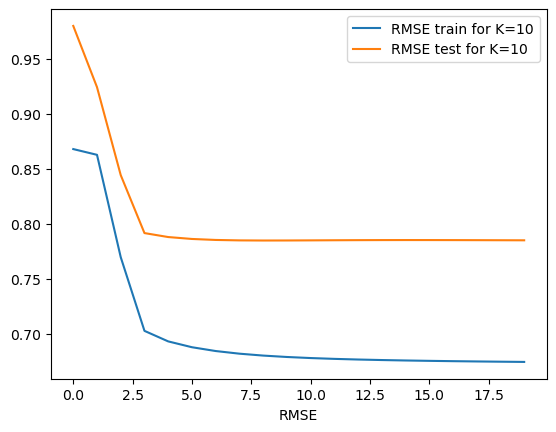

In [103]:
#Plotting the RMSE for the train and the test for k = 20.
import matplotlib.pyplot as plt
plt.plot(mse_train_list, label ='RMSE train for K=10')
plt.plot(mse_test_list, label = 'RMSE test for K=10')
plt.savefig('toky.k20.pdf', format = 'pdf', bbox_inches = 'tight')
plt.xlabel('RMSE')
plt.legend()

In [9]:
#Final training
M = len(data_by_user)
N = len(data_by_movie)

#initialize the biases.
user_biases = np.zeros(M)
movies_biases = np.zeros(N)
K= 20 #embedding dimension
p=1/np.sqrt(K) #ecart type of the distribuions

#initialize the embedding vectors
user_vector = np.random.normal(0,p, (M,K))
movie_vector = np.random.normal(0,p, (N,K))
epoch = 50 #number of epochs.
lamda = 0.002#lamda must be lower
gamma = 0.055
tau = 0.01#lower

#list for the values of the losses and the RMSE.
Loss_train_list = []
Loss_test_list = []
mse_train_list = []
mse_test_list = []

for i in range (epoch):

  #Calling the functions and update with all the data.
  user_biases, user_vector  = updtating_biases_vector_user(user_biases, movies_biases, user_vector, movie_vector, lamda, gamma, tau, data_by_user, data_by_movie)
  movies_biases, movie_vector = updtating_biases_vector_movie(user_biases, movies_biases, user_vector, movie_vector, lamda, gamma, tau, data_by_user, data_by_movie)
  Loss_train = loss_calculate(data_by_user_train, user_biases, movies_biases, user_vector, movie_vector, lamda, gamma,tau)
  rmse = rmse_calculate(data_by_user_train, user_biases, movies_biases, user_vector, movie_vector,lamda, gamma)

  mse_train_list.append(rmse)
  Loss_train_list.append(Loss_train)
  
  Loss_test = loss_calculate(data_by_user_test, user_biases, movies_biases, user_vector, movie_vector, lamda, gamma,tau)
  rmse_test = rmse_calculate(data_by_user_test, user_biases, movies_biases, user_vector, movie_vector,lamda, gamma)
 
  mse_test_list.append(rmse_test)
  Loss_test_list.append(Loss_test)

  if i<10 or (i>10 and i%10==0):
    print(f'epoch{i+1},  Loss train: {Loss_train}, Loss test: {Loss_test}, rmse : {rmse}, rmse test: {rmse_test}')



epoch1,  Loss train: -7020543.030169466, Loss test: -369424.3314696563, rmse : 0.8636508863634665, rmse test: 0.8639393457846927
epoch2,  Loss train: -4699056.47568656, Loss test: -247041.27284374234, rmse : 0.8590318189234922, rmse test: 0.8589272414100855
epoch3,  Loss train: -1885870.241004913, Loss test: -99230.8897579167, rmse : 0.7644572326762322, rmse test: 0.7640708929993154
epoch4,  Loss train: -1790116.1547793197, Loss test: -94185.57371113205, rmse : 0.7046884642600003, rmse test: 0.7041542916190776
epoch5,  Loss train: -1698858.0794161307, Loss test: -89377.12552257965, rmse : 0.6957273438348277, rmse test: 0.6951559444798037
epoch6,  Loss train: -1661412.8275540767, Loss test: -87403.44603971107, rmse : 0.6905237293644139, rmse test: 0.6899128315527006
epoch7,  Loss train: -1652307.3160128843, Loss test: -86922.81335168063, rmse : 0.68705742085477, rmse test: 0.6864278674342631
epoch8,  Loss train: -1662286.6013819806, Loss test: -87447.15394425395, rmse : 0.68462933862563

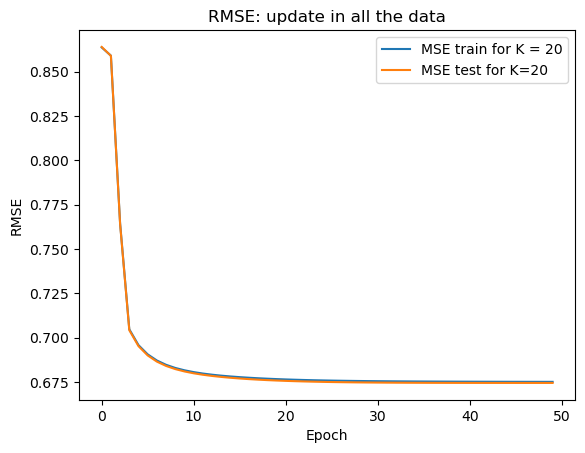

In [11]:
#Plotting the RMSE for the test and the train.
import matplotlib.pyplot as plt
plt.plot(mse_train_list, label = 'MSE train for K = 20')
plt.plot(mse_test_list, label = 'MSE test for K=20')
plt.title('RMSE: update in all the data')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.savefig('rmse.toky.all.pdf', format = 'pdf', bbox_inches = 'tight')
plt.legend()

In [13]:
#saving the vectors.
np.save('toky_user_biases.npy', user_biases)

In [16]:
np.save('toky_movies_biases.npy', movies_biases)
np.save('toky_user_vector.npy', user_vector)
np.save('toky_movie_vector.npy', movie_vector)

In [5]:
movie_vector = np.load('toky_movie_vector.npy')
movies_biases = np.load('toky_movies_biases.npy')

In [6]:
#transfome the movies csv in a dataframe
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
#Making the recommendations.
user = [(2189,2)] #dummy user
K = 20 #embed
lamda = 0.002#lamda must be lower
gamma = 0.055
tau = 0.01#lower
sigma = 1/np.sqrt(K) #ecart type of the distributions.

#initialize the vector of the dummy user
vector_new_user = np.random.normal(0, sigma, (1,K))

#initialize the rating predictions for all the movies.
score_item = np.zeros(len(data_by_movie))

#update the vector of the dummy user using the movies embedding and biases.
mat = np.zeros((K,K))
vec = np.zeros(K)
for (n,r) in user:
    vector_mov = movie_vector[n,:]
    mat += np.outer(vector_mov, vector_mov)
    vec += lamda*(r - movies_biases[n])*vector_mov
mat = lamda*(mat) + tau*(np.eye(K))
mat = np.linalg.inv(mat)
vector_new_user = np.dot(mat, vec)

#calculating the ratings for each movies.
for n in range(len(data_by_movie)):
    score_item[n] = np.dot(vector_new_user, movie_vector[n]) + movies_biases[n]
    
#ranking the movies by the highest ratings.
top_movie = np.argsort(score_item, axis = 0)[-5:][::-1]

#Taking the name of the movies liked by the dummy user
id_initial = map_idx_to_movie[2189]
name_movie_init = movies['title'][movies['movieId'] == int(id_initial)].values[0]
print(f'the initial movie is: {name_movie_init} and the recommendations are') 

#Printing the top 5 recommendations.
for i in range(5):
    idx_movie = top_movie[i]
    id_movie = map_idx_to_movie[idx_movie]
    name_movie = movies['title'][movies['movieId'] == int(id_movie)].values[0]
    print(name_movie) 



the initial movie is: Lord of the Rings, The (1978) and the recommendations are
Lord of the Rings: The Return of the King, The (2003)
Lord of the Rings: The Two Towers, The (2002)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Lord of the Rings, The (1978)
Star Wars: Episode I - The Phantom Menace (1999)
